# Time Series Sales — EDA 

This notebook walks through data understanding, feature creation, and baseline modeling for store sales time series.

**Facilitator notes**
- The original notebook contained HTML `<summary>` wrappers and local Windows file paths. This version removes those wrappers and uses a configurable `DATA_DIR`.
- Run the notebook top-to-bottom after setting `DATA_DIR`.


In [1]:
# Setup: configure data directory and basic imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path('data')  # change this to where your CSVs live

# Expected files (adjust as needed)
expected_files = [
    'train.csv',
    'test.csv',
    'stores.csv',
    'transactions.csv',
    'holidays_events.csv',
    'oil.csv',
    'sample_submission.csv'
]

missing = [f for f in expected_files if not (DATA_DIR / f).exists()]
print(missing)


['train.csv', 'test.csv', 'stores.csv', 'transactions.csv', 'holidays_events.csv', 'oil.csv', 'sample_submission.csv']


### Data Understanding plus EDA


import the necesarry libraries


In [2]:
#import the necesarry libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import os
import warnings
warnings.filterwarnings('ignore')


load the datasets


In [3]:
#load the datasets
train=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\train.csv')
holiday=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\holidays_events.csv')
oil=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\oil.csv')
sample=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\sample_submission.csv')
store=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\stores.csv')
test=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\test.csv')
transaction=pd.read_csv(r'C:\Users\Margaret Sasha\Downloads\Store Sales\transactions.csv')


check the shape of the data sets


In [4]:
#check the shape of the data sets
print('Train Shape:',train.shape)
print('Holiday Shape:',holiday.shape)
print('oil Shape:',oil.shape)
print('sample Shape:',sample.shape)
print('store Shape:',store.shape)
print('test Shape:',test.shape)
print('Transaction Shape:',transaction.shape)


Train Shape: (3000888, 6)
Holiday Shape: (350, 6)
oil Shape: (1218, 2)
sample Shape: (28512, 2)
store Shape: (54, 5)
test Shape: (28512, 5)
Transaction Shape: (83488, 3)


- #### checking the first few rows of each dataset


In [5]:
train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
holiday.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
oil.head()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
sample.head()


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [9]:
store.head()


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
test.head()


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [11]:
transaction.head()


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


converting the date columns to date data type as opposed to the object type


In [12]:
# converting the date columns to date data type as opposed to the object type
train['date']=pd.to_datetime(train['date'])
transaction['date']=pd.to_datetime(transaction['date'])
oil['date']=pd.to_datetime(oil['date'])
holiday['date']=pd.to_datetime(holiday['date'])
test['date']=pd.to_datetime(test['date'])


Checking on each dataset


In [13]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [14]:
#check for missing values
train.isnull().sum()


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
#check for duplicates
train.duplicated().sum()


0

In [16]:
train.describe()


,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [17]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [18]:
test.isnull().sum()


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [19]:
test.duplicated().sum()


0

In [20]:
test.describe()


,id,date,store_nbr,onpromotion
count,2.851200e+04,28512,28512.000000,28512.000000
mean,3.015144e+06,2017-08-23 12:00:00,27.500000,6.965383
min,3.000888e+06,2017-08-16 00:00:00,1.000000,0.000000
25%,3.008016e+06,2017-08-19 18:00:00,14.000000,0.000000
50%,3.015144e+06,2017-08-23 12:00:00,27.500000,0.000000
75%,3.022271e+06,2017-08-27 06:00:00,41.000000,6.000000
max,3.029399e+06,2017-08-31 00:00:00,54.000000,646.000000
std,8.230850e+03,NaN,15.586057,20.683952


In [21]:
holiday.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [22]:
holiday.isnull().sum()


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [23]:
holiday.duplicated().sum()


0

In [24]:
holiday.describe()


,date
count,350
mean,2015-04-24 00:45:15.428571392
min,2012-03-02 00:00:00
25%,2013-12-23 06:00:00
50%,2015-06-08 00:00:00
75%,2016-07-03 00:00:00
max,2017-12-26 00:00:00


In [25]:
sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [26]:
sample.isnull().sum()


id       0
sales    0
dtype: int64

In [27]:
sample.duplicated().sum()


0

In [28]:
sample.describe()


,id,sales
count,2.851200e+04,28512.0
mean,3.015144e+06,0.0
std,8.230850e+03,0.0
min,3.000888e+06,0.0
25%,3.008016e+06,0.0
50%,3.015144e+06,0.0
75%,3.022271e+06,0.0
max,3.029399e+06,0.0


In [29]:
oil.info()
# oil has some missing rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [30]:
oil.isnull().sum()


date           0
dcoilwtico    43
dtype: int64

In [31]:
oil.duplicated().sum()


0

In [32]:
oil.describe()


,date,dcoilwtico
count,1218,1175.000000
mean,2015-05-02 12:00:00,67.714366
min,2013-01-01 00:00:00,26.190000
25%,2014-03-03 06:00:00,46.405000
50%,2015-05-02 12:00:00,53.190000
75%,2016-06-30 18:00:00,95.660000
max,2017-08-31 00:00:00,110.620000
std,NaN,25.630476


In [33]:
## fill the missing values on oil using backwardfill
oil['dcoilwtico'].fillna(method='bfill',inplace=True)
oil.isnull().sum()


date          0
dcoilwtico    0
dtype: int64

In [34]:
store.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [35]:
store.isnull().sum()


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [36]:
store.duplicated().sum()


0

In [37]:
store.describe()


,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [38]:
transaction.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [39]:
transaction.isnull().sum()


date            0
store_nbr       0
transactions    0
dtype: int64

In [40]:
transaction.duplicated().sum()


0

In [41]:
transaction.describe()


,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
mean,2015-05-20 16:07:40.866232064,26.939237,1694.602158
min,2013-01-01 00:00:00,1.000000,5.000000
25%,2014-03-27 00:00:00,13.000000,1046.000000
50%,2015-06-08 00:00:00,27.000000,1393.000000
75%,2016-07-14 06:00:00,40.000000,2079.000000
max,2017-08-15 00:00:00,54.000000,8359.000000
std,NaN,15.608204,963.286644


In [42]:
## check 4 zero sales days
zero_sales=(train['sales']==0).sum()

print('total days where sales where zero',zero_sales)


total days where sales where zero 939130


Findings: In 939130 days there were zero sale days


sales skewness: 7.358757818882655


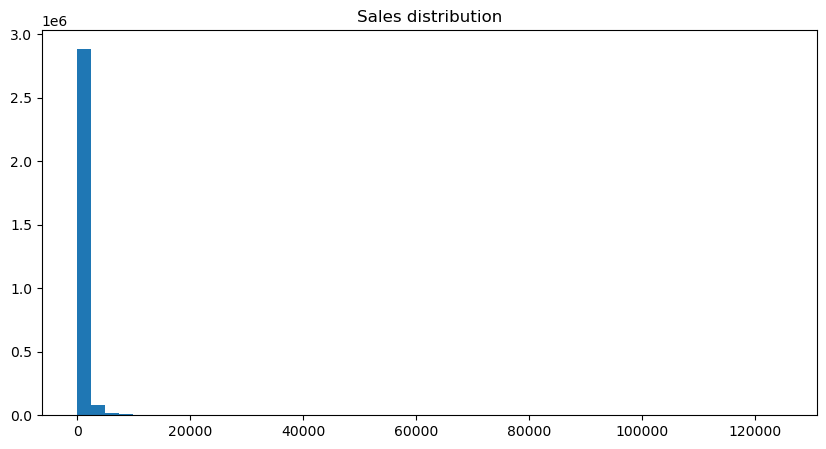

In [43]:
## check for the skewness of the sales and visualise it
skew=train['sales'].skew()
plt.figure(figsize=(10,5))
print('sales skewness:',skew)
plt.hist(train['sales'],bins=50)
plt.title('Sales distribution')
plt.show()


findings: the sales distribution is skewed to the left


In [44]:
##how many stores and families 
num_stores = train['store_nbr'].nunique()
num_families = train['family'].nunique()
print(f"Number of stores: {num_stores}")
print(f"Number of item families: {num_families}")


Number of stores: 54
Number of item families: 33


Plotting


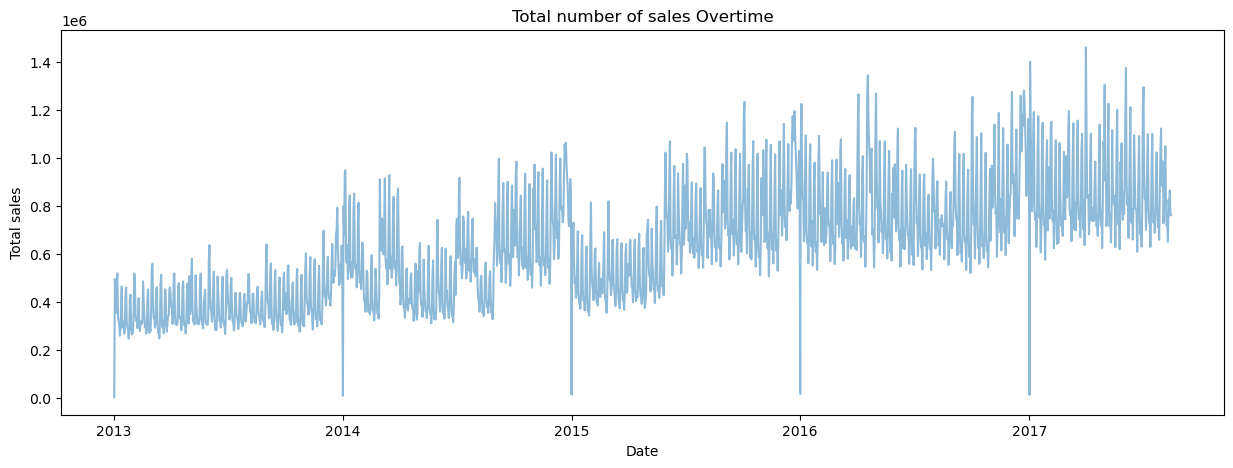

In [45]:
#we are going to visualise the trend of sales
#1. aggregate total sales per day
daily_sales= train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(15,5))
plt.plot(daily_sales['date'],daily_sales['sales'],alpha=0.5,label='daily sales')
plt.title('Total number of sales Overtime')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.show()


### Findings
1. it is clear from the chart that the sales significantly drop at the begining of each year up to alpmost zero
2. the trend rises upwards each year, this means that the sales gradually increases each year
3. the sales was in its all time high sometime in 2017,the date is not clear


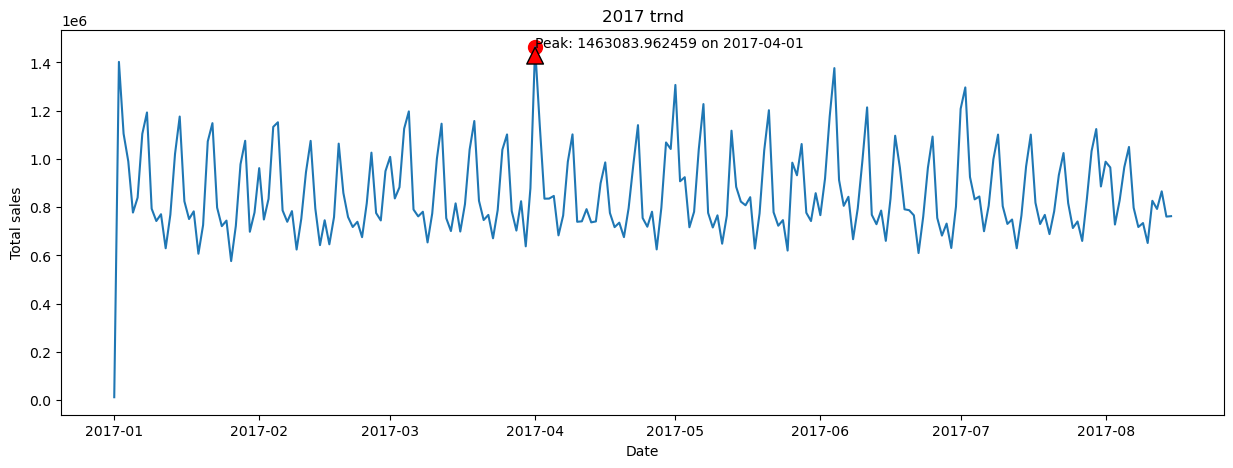

In [46]:
## we can further visualise the date when at its all time high 2017
# Filter for 2017
sales2017 = daily_sales[daily_sales['date'].dt.year == 2017]
# Find the date of all-time high in 2017
max_idx = sales2017['sales'].idxmax()
max_date = sales2017.loc[max_idx, 'date']
max_sales = sales2017.loc[max_idx, 'sales']

plt.figure(figsize=(15,5))
plt.plot(sales2017['date'],sales2017['sales'], label='2017 Peak')
# Highlight the 2017 peak
plt.scatter(max_date, max_sales, color='red', s=100, label='2017 Peak')
plt.annotate(f'Peak: {max_sales} on {max_date.date()}', 
             xy=(max_date, max_sales), xytext=(max_date, max_sales+500),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)
plt.title('2017 trnd')
plt.xlabel('Date')
plt.ylabel('Total sales') 
plt.show()


1. the day with the highest sale according to the chart is 01/04/2017 and the sales achieved was 1463083.962459
2. overally, the sales are pretty consistent throughout the year not showing an upward or downward trends
3. The year 2017 has a regular partern  and valleys suggesting a strong weekly cycle


In [47]:
## Visualise the data on stores
#1.aggregate the sales by stores 

store_sales=train.groupby('store_nbr')['sales'].sum().reset_index().sort_values('sales',ascending=False)
store_sales.tail()


,store_nbr,sales
34,35,7.676679e+06
29,30,7.382074e+06
31,32,5.951796e+06
21,22,4.090202e+06
51,52,2.696170e+06


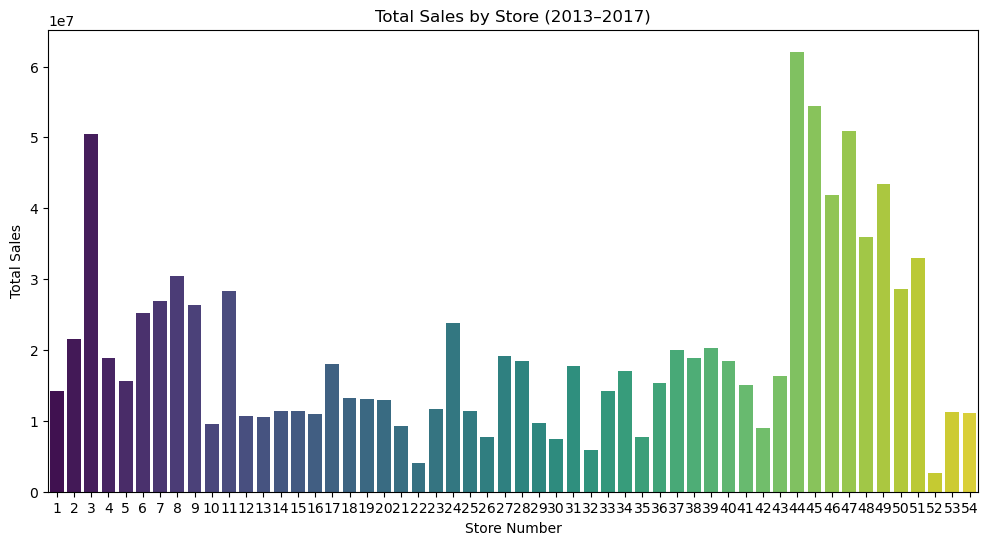

In [48]:
plt.figure(figsize=(12,6))
sns.barplot(x='store_nbr', y='sales', data=store_sales.sort_values('sales', ascending=False), palette='viridis')
plt.title("Total Sales by Store (2013–2017)")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.show()


1. The store with the highest amount of Sales was store no. 44 while store no. 52 had the lowest sales amongst all stores


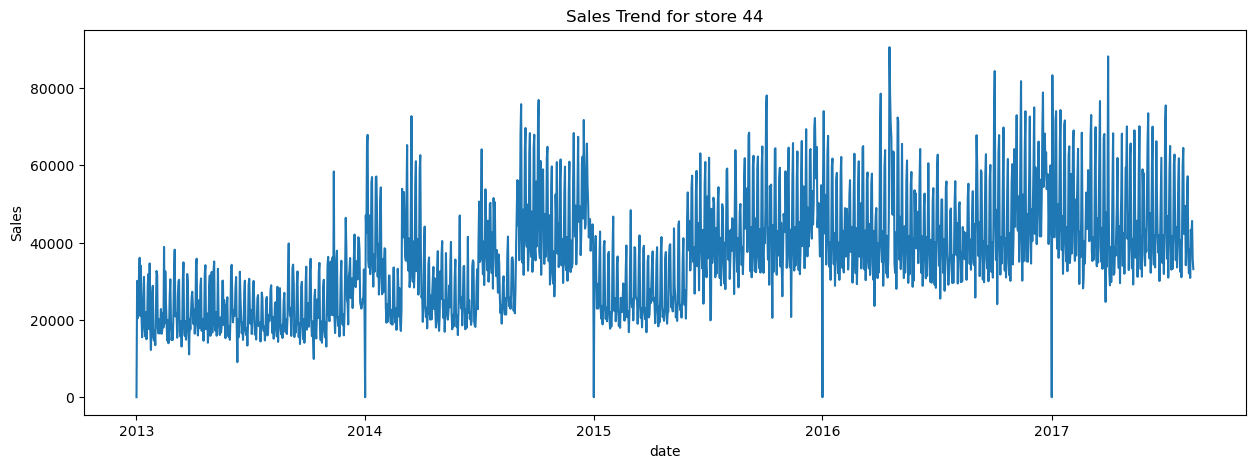

In [49]:
#visualise the sales overtime for the best store
store44=train[train['store_nbr']==44]
dailystore44sales=store44.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(x='date',y='sales',data=dailystore44sales)
plt.title('Sales Trend for store 44')
plt.xlabel('date')
plt.ylabel('Sales')
plt.show()


1. the trend is slowly rising throughout the years although not as much as compared to the overall with 2017 sales being very high
2. the sales are significantly low at the beginning of every year,probably due to the new tear holidays,the stores are probably closed for the new year
   


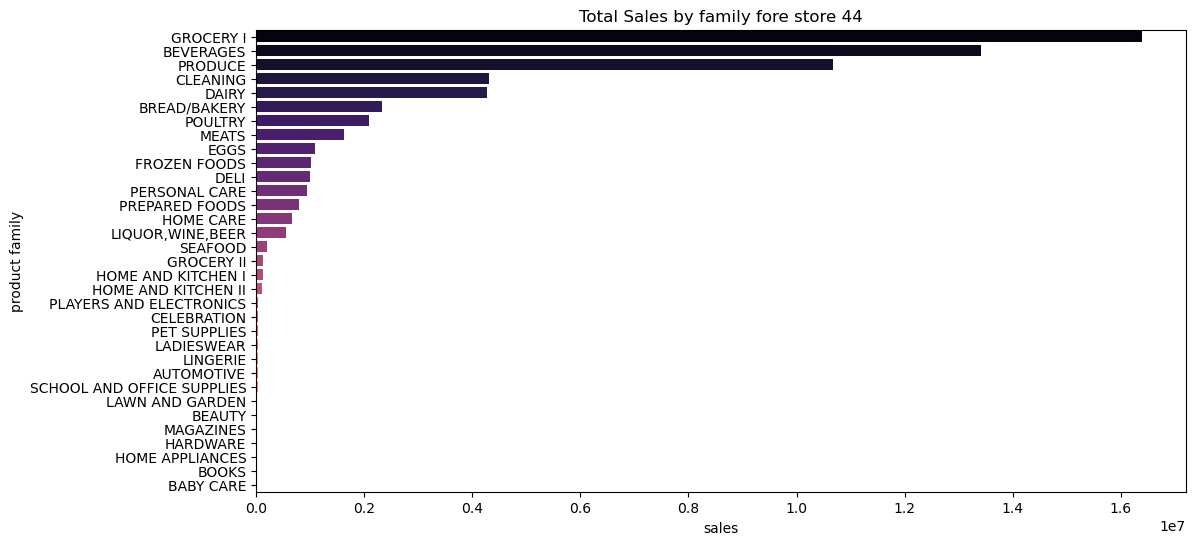

In [50]:
#visualise how the families perform in this store
family_sales44=store44.groupby('family')['sales'].sum().reset_index()
family_sales44=family_sales44.sort_values('sales',ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(y='family', x='sales', data=family_sales44, palette='magma')
plt.title("Total Sales by family fore store 44")
plt.xlabel("sales")
plt.ylabel("product family")
plt.show()


Grocery 1brings in the largest number of sales,2 is  beverages and 3 produce while babycare brings in the lowest could be explained by the fact that most people need food and e.t.c to survive while not a lot of peole have children


In [51]:
#create a new column promo flag that checks on the days in which there were promotions0 for false,1 for true
store44['promo_flag'] = (store44['onpromotion'] > 0).astype(int)


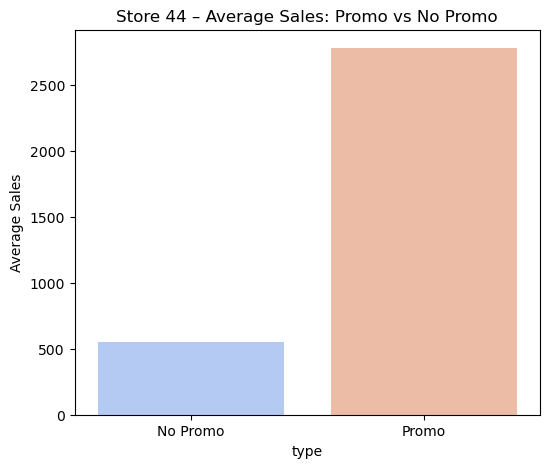

In [52]:
#visualise sales on the days that there was promotions vs when there was none
promo_avg = store44.groupby('promo_flag')['sales'].mean().reset_index()
promo_avg['type'] = promo_avg['promo_flag'].map({0:'No Promo', 1:'Promo'})

plt.figure(figsize=(6,5))
sns.barplot(x='type', y='sales', data=promo_avg, palette='coolwarm')
plt.title("Store 44 – Average Sales: Promo vs No Promo")
plt.ylabel("Average Sales")
plt.show()


There was more sales on the days that there was promotions which clearly indicate that the promotions are a key contributor to the number of sales hence contributing to the success of store 44


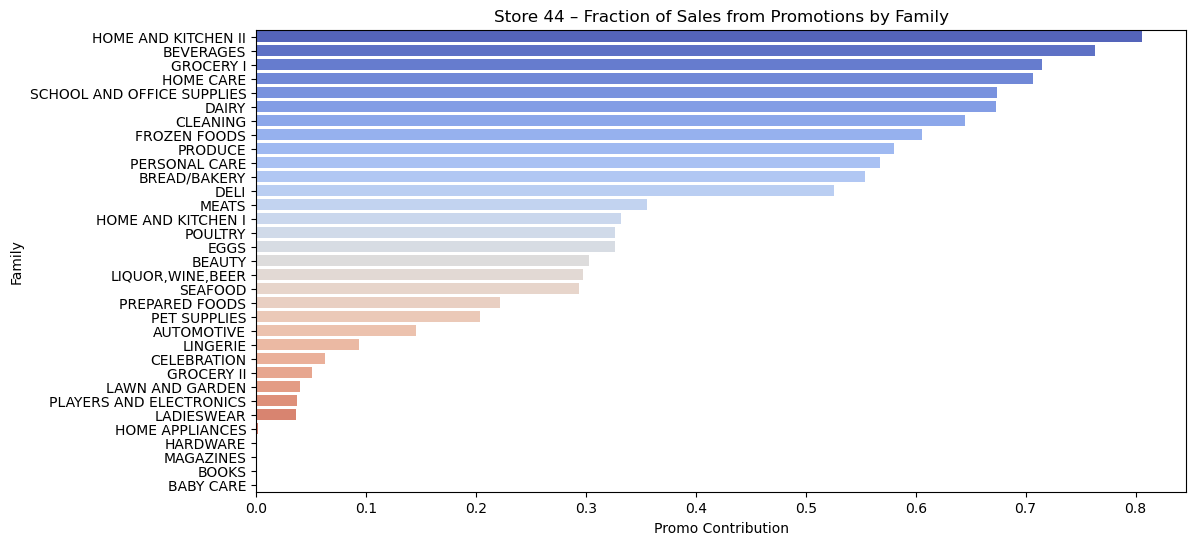

In [53]:
promo_family = store44.groupby('family').agg(
    promo_sales=('sales', lambda x: x[store44['onpromotion']>0].sum()),
    total_sales=('sales','sum')
).reset_index()

promo_family['promo_ratio'] = promo_family['promo_sales'] / promo_family['total_sales']
plt.figure(figsize=(12,6))
sns.barplot(x='promo_ratio', y='family', data=promo_family.sort_values('promo_ratio', ascending=False), palette='coolwarm')
plt.title("Store 44 – Fraction of Sales from Promotions by Family")
plt.xlabel("Promo Contribution")
plt.ylabel("Family")
plt.show()


The top three families in terms of promotion-driven sales are Home & Kitchen 2, Beverages, and Grocery, meaning these items see the largest sales boost when promoted. In contrast, the top three families by overall sales are Grocery, Beverages, and Produce, highlighting that promo impact does not always align with total sales performance.


#### Analysing the Lowest Performing Store,52


In [54]:
#isolate it frm the train data set
store_52 = train[train['store_nbr'] == 52].copy()
store_52.head()


,id,date,store_nbr,family,sales,onpromotion
1551,1551,2013-01-01,52,AUTOMOTIVE,0.0,0
1552,1552,2013-01-01,52,BABY CARE,0.0,0
1553,1553,2013-01-01,52,BEAUTY,0.0,0
1554,1554,2013-01-01,52,BEVERAGES,0.0,0
1555,1555,2013-01-01,52,BOOKS,0.0,0


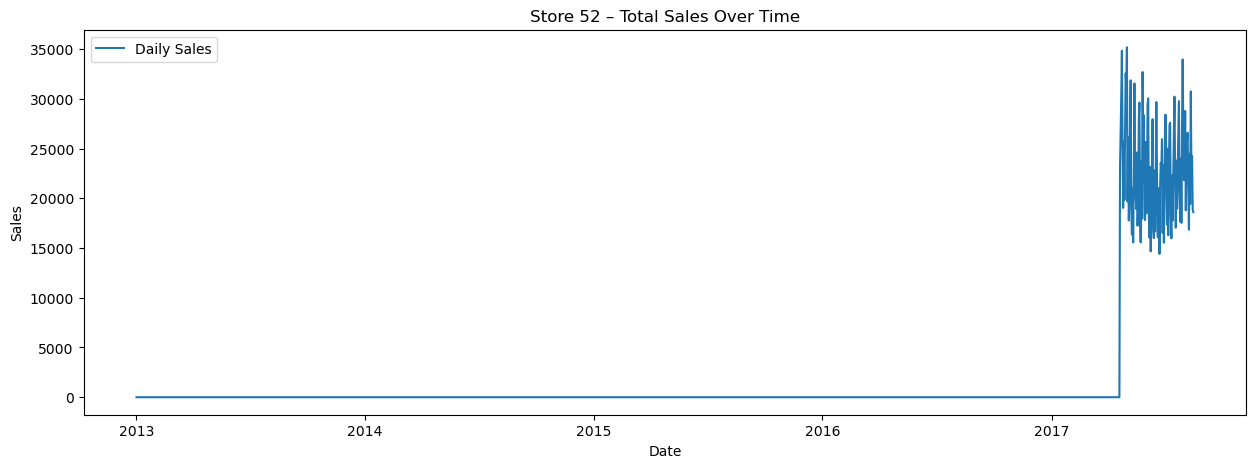

In [55]:
daily_sales_52=store_52.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', data=daily_sales_52, label='Daily Sales')
plt.title("Store 52 – Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


the sales were pretty much zero up until 2017 where it began to rise suggesting that this is a newly openned store


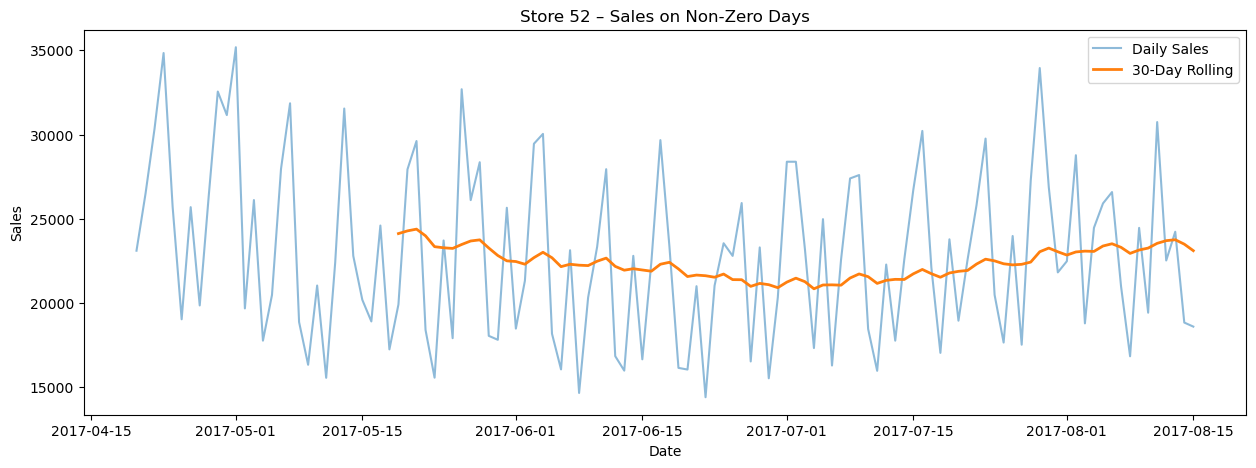

In [56]:
#Visualising the sales on non zero days
# Filter only days with sales > 0
store_52_nonzero = store_52[store_52['sales'] > 0]

# Group by date to get total sales per day
daily_sales_nonzero = store_52_nonzero.groupby('date')['sales'].sum().reset_index()
# Filter only days with sales > 0
store_52_nonzero = store_52[store_52['sales'] > 0]
daily_sales_nonzero['rolling_30'] = daily_sales_nonzero['sales'].rolling(30).mean()

# Plot
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', data=daily_sales_nonzero, alpha=0.5, label='Daily Sales')
sns.lineplot(x='date', y='rolling_30', data=daily_sales_nonzero, linewidth=2, label='30-Day Rolling')
plt.title("Store 52 – Sales on Non-Zero Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


Sales for Store 52 on non-zero days show a zigzag pattern, indicating inconsistent daily demand. Peaks and troughs appear irregularly, suggesting that customer purchases fluctuate significantly from day to day, likely influenced by factors such as promotions, stock availability, or seasonal effects. The lack of a smooth trend highlights that the store is still in an early growth phase and has not yet reached stable, predictable sales patterns


Store 52’s low performance is largely due to its newness and early-stage growth, and any analysis prior to 2017 is less meaningful. Post-2017 data provides the first meaningful signal for family and promotion-driven analysis.


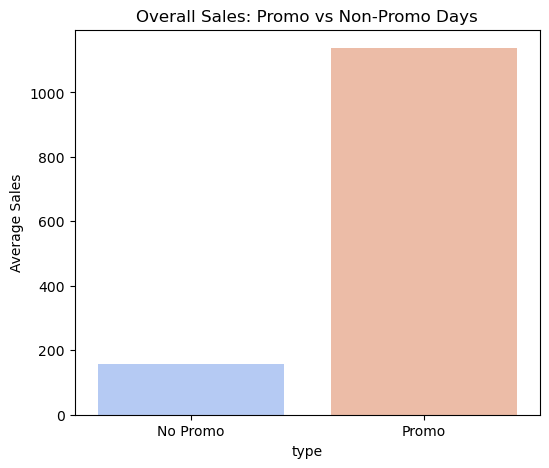

In [57]:
train['promo_flag'] = (train['onpromotion'] > 0).astype(int)
promo_avg_all = train.groupby('promo_flag')['sales'].mean().reset_index()
promo_avg_all['type'] = promo_avg_all['promo_flag'].map({0:'No Promo', 1:'Promo'})

plt.figure(figsize=(6,5))
sns.barplot(x='type', y='sales', data=promo_avg_all, palette='coolwarm')
plt.title("Overall Sales: Promo vs Non-Promo Days")
plt.ylabel("Average Sales")
plt.show()


Across all stores and families, sales on promotion days are consistently higher than non-promo days, confirming that promotions drive revenue. This validates promo_flag as a strong predictive feature for forecasting models


Look at seasonality (weekly/monthly)


In [58]:
# Adding date features. Extract day of week, week of year, month
train['day_of_week'] = train['date'].dt.day_name()      # Monday, Tuesday, etc.
train['week_of_year'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month


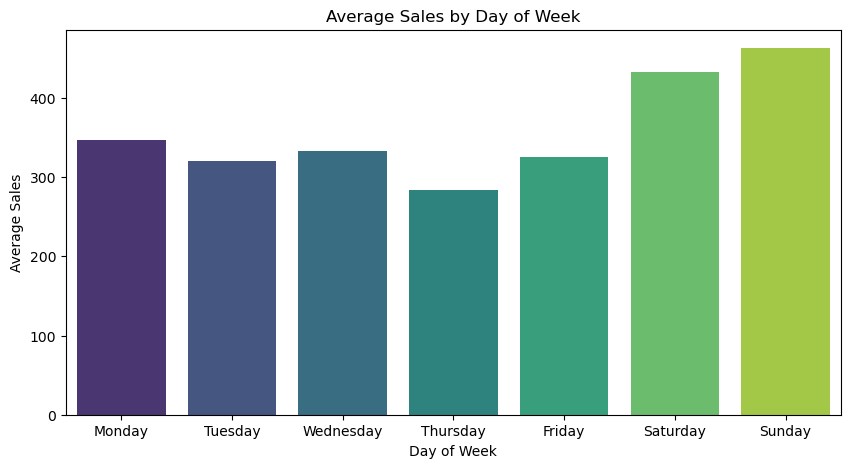

In [59]:
#Average sales by day of the week,
weekly_sales = train.groupby('day_of_week')['sales'].mean().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
]).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y='sales', data=weekly_sales, palette='viridis')
plt.title("Average Sales by Day of Week")
plt.ylabel("Average Sales")
plt.xlabel("Day of Week")
plt.show()


Sales are highest on Saturdays and Sundays and lowest on Thursdays, indicating a strong weekend shopping effect.


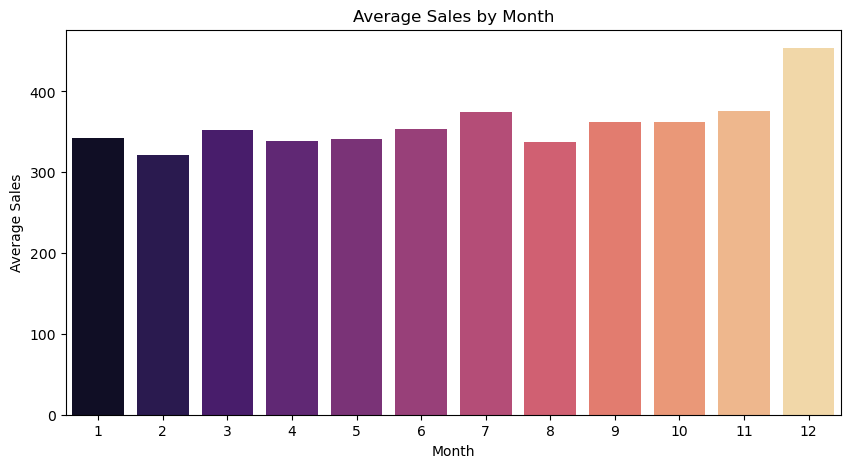

In [60]:
#Average sales per month:
monthly_sales = train.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='month', y='sales', data=monthly_sales, palette='magma')
plt.title("Average Sales by Month")
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.show()


On average, December records the highest sales, likely due to seasonal shopping and holidays.


In [61]:
holiday.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [62]:
holiday['type'].unique()


array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [64]:
#merging the holiday dataset to do further analysis
holiday['date'] = pd.to_datetime(holiday['date'])
train = train.merge(holiday[['date','type']], on='date', how='left')


In [65]:
#creating a holiday flag
train['is_holiday'] = (~train['type'].isna()).astype(int)


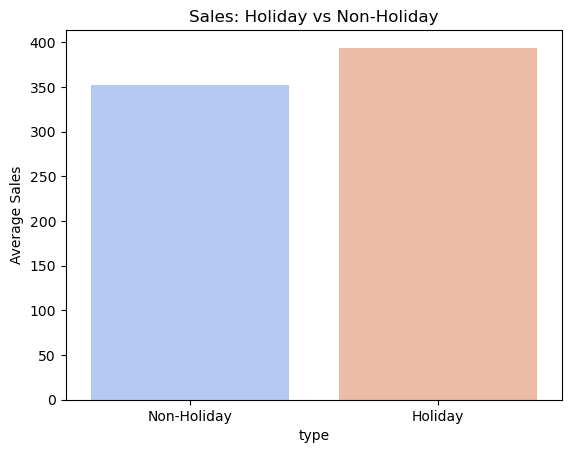

In [66]:
holiday_sales = train.groupby('is_holiday')['sales'].mean().reset_index()
holiday_sales['type'] = holiday_sales['is_holiday'].map({0:'Non-Holiday', 1:'Holiday'})

sns.barplot(x='type', y='sales', data=holiday_sales, palette='coolwarm')
plt.title("Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Sales")
plt.show()


Sales on holidays are slightly higher than non-holidays, with an average difference of about 50 units.

This is not a major driver of total sales for the stores in this dataset.

Implication: Holidays can be included as a feature, but they are not as strong as promotions, weekly seasonality, or product-family effects.
